
# Predicting Accidents in New York City
## Capstone Project 2
### Gene Hopping
### Springboard Data Science Career Track

# Contents <a id='Contents'/>

[Data wrangling](#data_wrangling)

[EDA](#EDA)

[Conversion of latitude and longitude to mercator](#mercator)

[Plots]

[Generating the rastor]




The Model:
## Use convLSTM
https://keras.io/layers/recurrent/ - convLSTM2D section
http://bsautermeister.de/research/docs/msc_thesis.pdf
https://www.quora.com/What-is-the-difference-between-ConvLSTM-and-CNN-LSTM


THings I need to look into:
Temporal-spatial data. Will want ability to plot onto a map
raster - but do I have ability to map to street.iontersection rather than a cell of a matrix?
Incorporate weather data? Sunrise/sunset (E-W roads?)


[Back to Contents](#Contents)

## Data Wrangling<a id='data_wrangling'/>

In [42]:
#import libraries
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
#import geopandas
#from osgeo import gdal
import seaborn as sns
import numpy as np
from pyproj import Proj, transform
import folium
from folium.plugins import HeatMap

In [43]:
#low_memory=False because error recieved: Columns (3) have mixed types
traffic_df = pd.read_csv('NYPD_Motor_Vehicle_Collisions.csv', low_memory=False) #parse_dates=[['DATE', 'TIME']]

#data_source = 'https://data.cityofnewyork.us/resource/qiz3-axqb.json'
#traffic_df = pd.read_json(data_source)


In [44]:
traffic_df.head(10)

,DATE,TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,UNIQUE KEY,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,04/16/2019,0:00,MANHATTAN,10010,40.737885,-73.98091,"(40.737885, -73.98091)",2 AVENUE,EAST 23 STREET,NaN,...,Traffic Control Disregarded,NaN,NaN,NaN,4116367,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
1,04/16/2019,0:00,QUEENS,11354,40.762756,-73.82261,"(40.762756, -73.82261)",PARSONS BOULEVARD,38 AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,4115878,Sedan,Box Truck,NaN,NaN,NaN
2,04/16/2019,0:00,QUEENS,11367,40.729404,-73.82282,"(40.729404, -73.82282)",NaN,NaN,144-04 70 AVENUE,...,Unspecified,NaN,NaN,NaN,4115808,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
3,04/16/2019,0:00,QUEENS,11413,40.665485,-73.75374,"(40.665485, -73.75374)",SOUTH CONDUIT AVENUE,224 STREET,NaN,...,Unspecified,NaN,NaN,NaN,4115916,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN
4,04/16/2019,0:00,NaN,NaN,40.810173,-73.95117,"(40.810173, -73.95117)",WEST 125 STREET,NaN,NaN,...,Driver Inattention/Distraction,NaN,NaN,NaN,4116309,Station Wagon/Sport Utility Vehicle,Taxi,NaN,NaN,NaN
5,04/16/2019,0:00,NaN,NaN,40.845180,-73.91417,"(40.84518, -73.91417)",JEROME AVENUE,NaN,NaN,...,Driver Inattention/Distraction,NaN,NaN,NaN,4116124,Sedan,Motorcycle,NaN,NaN,NaN
6,04/16/2019,0:30,NaN,NaN,NaN,NaN,NaN,NASSAU EXPRESSWAY,NaN,NaN,...,NaN,NaN,NaN,NaN,4115410,Sedan,NaN,NaN,NaN,NaN
7,04/16/2019,0:35,MANHATTAN,10034,40.866740,-73.92873,"(40.86674, -73.92873)",DYCKMAN STREET,PAYSON AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,4115854,Sedan,Sedan,NaN,NaN,NaN
8,04/16/2019,0:46,MANHATTAN,10025,40.802372,-73.96431,"(40.802372, -73.96431)",WEST 109 STREET,AMSTERDAM AVENUE,NaN,...,Passing Too Closely,NaN,NaN,NaN,4116114,Garbage or Refuse,Sedan,NaN,NaN,NaN
9,04/16/2019,0:49,BRONX,10453,40.861862,-73.91282,"(40.861862, -73.91282)",MAJOR DEEGAN EXPRESSWAY,WEST FORDHAM ROAD,NaN,...,Unspecified,NaN,NaN,NaN,4115377,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN


Thoughts on a quick inspection of above:
-Will want to merge the DATE AND TIME columns and put into propper DateTime format and make the index (pandas foundations
-Looks like the LOCATION column contains the same information as LAT AND LONG - take a deeper look.
-Unsure if UNIQUE KEY is important - look into this, drop if just duplicated data
-Values of 00:00 is probably a value used if time not recorded.

Let's see what the missing columns in middle are, and what level of missing 

Exploratory Data Analysis

In [45]:
#take a look at column titles
traffic_df.columns

Index(['DATE', 'TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE',
       'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME',
       'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED',
       'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED',
       'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED',
       'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED',
       'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2',
       'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4',
       'CONTRIBUTING FACTOR VEHICLE 5', 'UNIQUE KEY', 'VEHICLE TYPE CODE 1',
       'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4',
       'VEHICLE TYPE CODE 5'],
      dtype='object')

Change to lower case and get rid of those spaces

In [46]:
#convert upper case to lower case
traffic_df.columns = map(str.lower, traffic_df.columns)

In [47]:
#replace blank spaces with underscore
traffic_df.columns = traffic_df.columns.str.replace(" ", "_") #can I use this format above?

In [48]:
traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1480084 entries, 0 to 1480083
Data columns (total 29 columns):
date                             1480084 non-null object
time                             1480084 non-null object
borough                          1037441 non-null object
zip_code                         1037266 non-null object
latitude                         1294208 non-null float64
longitude                        1294208 non-null float64
location                         1294208 non-null object
on_street_name                   1196093 non-null object
cross_street_name                1007087 non-null object
off_street_name                  191840 non-null object
number_of_persons_injured        1480067 non-null float64
number_of_persons_killed         1480053 non-null float64
number_of_pedestrians_injured    1480084 non-null int64
number_of_pedestrians_killed     1480084 non-null int64
number_of_cyclist_injured        1480084 non-null int64
number_of_cyclist_killed        

In [49]:
#---------Keep for now, but using parse_dates upon read_csv seems to take care of this ----------------#

#convert date and time to datetime object in case it's more convenient later
traffic_df['datetime'] = pd.to_datetime(traffic_df['date'] + ' ' + traffic_df['time'])
#set date  type to datetime64
traffic_df.date = traffic_df.date.astype("datetime64")
# Probably neet to convert time to something - may be able to use datetime instead.
traffic_df = traffic_df.set_index(pd.DatetimeIndex(traffic_df['datetime']))

In [50]:
#Take a look
traffic_df.head(5)

,date,time,borough,zip_code,latitude,longitude,location,on_street_name,cross_street_name,off_street_name,...,contributing_factor_vehicle_3,contributing_factor_vehicle_4,contributing_factor_vehicle_5,unique_key,vehicle_type_code_1,vehicle_type_code_2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5,datetime
datetime,,,,,,,,,,,,,,,,,,,,,
2019-04-16,2019-04-16,0:00,MANHATTAN,10010,40.737885,-73.98091,"(40.737885, -73.98091)",2 AVENUE,EAST 23 STREET,NaN,...,NaN,NaN,NaN,4116367,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,2019-04-16
2019-04-16,2019-04-16,0:00,QUEENS,11354,40.762756,-73.82261,"(40.762756, -73.82261)",PARSONS BOULEVARD,38 AVENUE,NaN,...,NaN,NaN,NaN,4115878,Sedan,Box Truck,NaN,NaN,NaN,2019-04-16
2019-04-16,2019-04-16,0:00,QUEENS,11367,40.729404,-73.82282,"(40.729404, -73.82282)",NaN,NaN,144-04 70 AVENUE,...,NaN,NaN,NaN,4115808,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,2019-04-16
2019-04-16,2019-04-16,0:00,QUEENS,11413,40.665485,-73.75374,"(40.665485, -73.75374)",SOUTH CONDUIT AVENUE,224 STREET,NaN,...,NaN,NaN,NaN,4115916,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN,2019-04-16
2019-04-16,2019-04-16,0:00,NaN,NaN,40.810173,-73.95117,"(40.810173, -73.95117)",WEST 125 STREET,NaN,NaN,...,NaN,NaN,NaN,4116309,Station Wagon/Sport Utility Vehicle,Taxi,NaN,NaN,NaN,2019-04-16


In [51]:
#Plot 2 weeks worth of histograms, week of july 4 2018

two_weeks = traffic_df.loc['2018-07-15':'2018-07-29']
#ax = df.plot(kind='bar', color='b')
#ticklabels = df.index.strftime('%H:%Mh')
#ax.xaxis.set_major_formatter(matplotlib.ticker.FixedFormatter(ticklabels))
#plt.show()
two_weeks.head()

,date,time,borough,zip_code,latitude,longitude,location,on_street_name,cross_street_name,off_street_name,...,contributing_factor_vehicle_3,contributing_factor_vehicle_4,contributing_factor_vehicle_5,unique_key,vehicle_type_code_1,vehicle_type_code_2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5,datetime
datetime,,,,,,,,,,,,,,,,,,,,,
2018-07-29,2018-07-29,0:00,BRONX,10465,40.830260,-73.820400,"(40.83026, -73.8204)",NaN,NaN,823 THROGS NECK EXPRESSWAY,...,NaN,NaN,NaN,3952254,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN,2018-07-29
2018-07-29,2018-07-29,0:00,BROOKLYN,11224,40.572840,-73.999370,"(40.57284, -73.99937)",NaN,NaN,3309 SURF AVENUE,...,NaN,NaN,NaN,3950791,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN,2018-07-29
2018-07-29,2018-07-29,0:00,QUEENS,11412,40.699066,-73.766990,"(40.699066, -73.76699)",MAYVILLE STREET,MANGIN AVENUE,NaN,...,NaN,NaN,NaN,3951595,Sedan,Sedan,NaN,NaN,NaN,2018-07-29
2018-07-29,2018-07-29,0:00,NaN,NaN,40.830112,-73.850266,"(40.830112, -73.850266)",CROSS BRONX EXPY,NaN,NaN,...,NaN,NaN,NaN,3950323,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,2018-07-29
2018-07-29,2018-07-29,0:00,BROOKLYN,11208,40.683792,-73.868510,"(40.683792, -73.86851)",NaN,NaN,280 NICHOLS AVENUE,...,NaN,NaN,NaN,3950705,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,2018-07-29


In [52]:

counts = []

date_range = pd.date_range(start='2018-07-15', end='2018-07-28', freq='D').date
for i in date_range:
    counts.append(two_weeks.loc[i].time.groupby(pd.Grouper(freq='H')).count())

counts
    
    #print(two_weeks.loc[i].date)
   # two_weeks.date.groupby(pd.Grouper(freq='H')).count()

[datetime
 2018-07-15    10
 Freq: H, Name: time, dtype: int64, datetime
 2018-07-16    7
 Freq: H, Name: time, dtype: int64, datetime
 2018-07-17    10
 Freq: H, Name: time, dtype: int64, datetime
 2018-07-18    12
 Freq: H, Name: time, dtype: int64, datetime
 2018-07-19    10
 Freq: H, Name: time, dtype: int64, datetime
 2018-07-20    6
 Freq: H, Name: time, dtype: int64, datetime
 2018-07-21    5
 Freq: H, Name: time, dtype: int64, datetime
 2018-07-22    10
 Freq: H, Name: time, dtype: int64, datetime
 2018-07-23    10
 Freq: H, Name: time, dtype: int64, datetime
 2018-07-24    9
 Freq: H, Name: time, dtype: int64, datetime
 2018-07-25    9
 Freq: H, Name: time, dtype: int64, datetime
 2018-07-26    7
 Freq: H, Name: time, dtype: int64, datetime
 2018-07-27    10
 Freq: H, Name: time, dtype: int64, datetime
 2018-07-28    6
 Freq: H, Name: time, dtype: int64]

In [53]:
#Loop over each day and count entries per hour. Want to get this so I can produce histograms
date_range = pd.date_range(start='2018-07-15', end='2018-07-29', freq='D').date
day = []
for x in date_range:
    day.append(two_weeks[two_weeks.date == str(x)].date.groupby(pd.Grouper(freq='H')).count())
    next

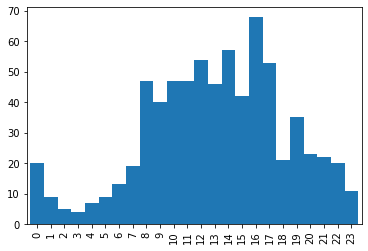

In [54]:
#plot one day of counts
day_np = np.array(day)
#plt.plot(day_np[0], kind='column')
day_df = pd.DataFrame(day_np)#, index=date_range)
day_df.iloc[1,:].plot.bar(width=1)

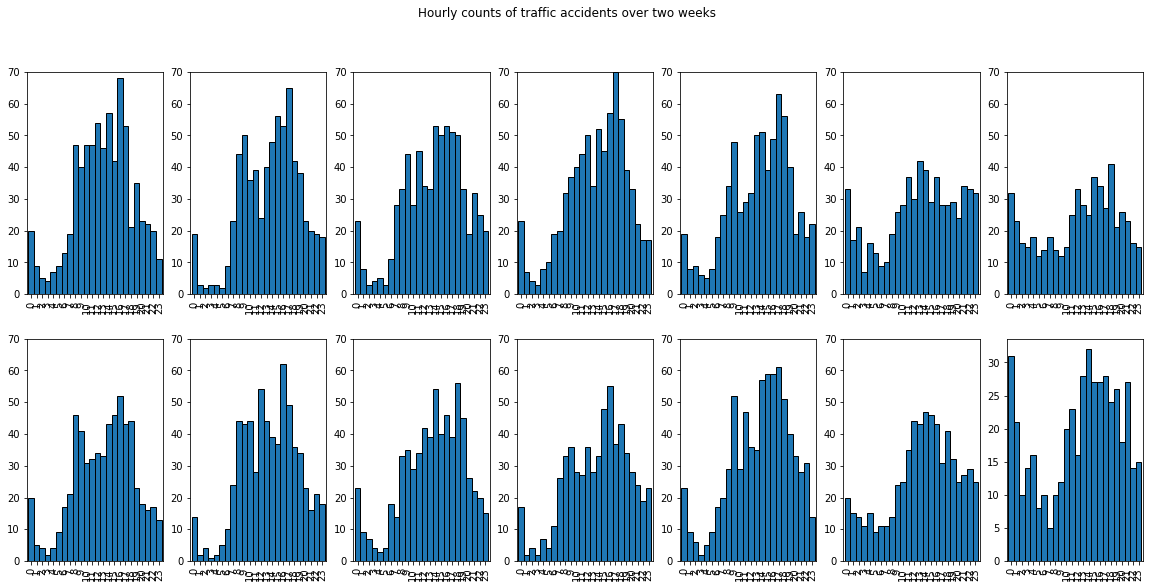

In [55]:
#loop over 2 weeks of data and plot histograms
for i in range(1,15,1):
    plt.rcParams["figure.figsize"] = (20, 9) # (w, h)
    plt.ylim((0,70))
    plt.suptitle('Hourly counts of traffic accidents over two weeks')
    plt.subplot(2,7,i)
    _ = day_df.iloc[i,:].plot.bar(width=1, edgecolor='k')
    plt.savefig('2weeks_hist.png')

In [16]:
#Replace Nan with 0 then remove all lines with 0 in lat and long.
traffic_df.latitude = traffic_df.latitude.fillna(0)
#traffic_df = traffic_df.longitude.fillna(0)
plt.save

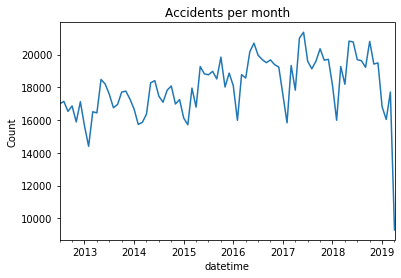

In [58]:
#Take a look at number of accidents over time
%matplotlib inline
monthly_count = traffic_df['date'].resample('MS').count()
_ = monthly_count.plot()
_ = plt.title('Accidents per month')
_ = plt.ylabel('Count')
plt.savefig('accidents_month.png')


In [60]:
traffic_df.head(5)

,date,time,borough,zip_code,latitude,longitude,location,on_street_name,cross_street_name,off_street_name,...,contributing_factor_vehicle_3,contributing_factor_vehicle_4,contributing_factor_vehicle_5,unique_key,vehicle_type_code_1,vehicle_type_code_2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5,datetime
datetime,,,,,,,,,,,,,,,,,,,,,
2019-04-16,2019-04-16,0:00,MANHATTAN,10010,40.737885,-73.98091,"(40.737885, -73.98091)",2 AVENUE,EAST 23 STREET,NaN,...,NaN,NaN,NaN,4116367,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,2019-04-16
2019-04-16,2019-04-16,0:00,QUEENS,11354,40.762756,-73.82261,"(40.762756, -73.82261)",PARSONS BOULEVARD,38 AVENUE,NaN,...,NaN,NaN,NaN,4115878,Sedan,Box Truck,NaN,NaN,NaN,2019-04-16
2019-04-16,2019-04-16,0:00,QUEENS,11367,40.729404,-73.82282,"(40.729404, -73.82282)",NaN,NaN,144-04 70 AVENUE,...,NaN,NaN,NaN,4115808,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,2019-04-16
2019-04-16,2019-04-16,0:00,QUEENS,11413,40.665485,-73.75374,"(40.665485, -73.75374)",SOUTH CONDUIT AVENUE,224 STREET,NaN,...,NaN,NaN,NaN,4115916,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN,2019-04-16
2019-04-16,2019-04-16,0:00,NaN,NaN,40.810173,-73.95117,"(40.810173, -73.95117)",WEST 125 STREET,NaN,NaN,...,NaN,NaN,NaN,4116309,Station Wagon/Sport Utility Vehicle,Taxi,NaN,NaN,NaN,2019-04-16


In [20]:
traffic_df.longitude = traffic_df.longitude.fillna(0)

In [21]:
traffic_df.head(5)

,date,time,borough,zip_code,latitude,longitude,location,on_street_name,cross_street_name,off_street_name,...,contributing_factor_vehicle_3,contributing_factor_vehicle_4,contributing_factor_vehicle_5,unique_key,vehicle_type_code_1,vehicle_type_code_2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5,datetime
datetime,,,,,,,,,,,,,,,,,,,,,
2019-04-16,2019-04-16,0:00,MANHATTAN,10010,40.737885,-73.98091,"(40.737885, -73.98091)",2 AVENUE,EAST 23 STREET,NaN,...,NaN,NaN,NaN,4116367,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,2019-04-16
2019-04-16,2019-04-16,0:00,QUEENS,11354,40.762756,-73.82261,"(40.762756, -73.82261)",PARSONS BOULEVARD,38 AVENUE,NaN,...,NaN,NaN,NaN,4115878,Sedan,Box Truck,NaN,NaN,NaN,2019-04-16
2019-04-16,2019-04-16,0:00,QUEENS,11367,40.729404,-73.82282,"(40.729404, -73.82282)",NaN,NaN,144-04 70 AVENUE,...,NaN,NaN,NaN,4115808,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,2019-04-16
2019-04-16,2019-04-16,0:00,QUEENS,11413,40.665485,-73.75374,"(40.665485, -73.75374)",SOUTH CONDUIT AVENUE,224 STREET,NaN,...,NaN,NaN,NaN,4115916,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN,2019-04-16
2019-04-16,2019-04-16,0:00,NaN,NaN,40.810173,-73.95117,"(40.810173, -73.95117)",WEST 125 STREET,NaN,NaN,...,NaN,NaN,NaN,4116309,Station Wagon/Sport Utility Vehicle,Taxi,NaN,NaN,NaN,2019-04-16


In [22]:
traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1480084 entries, 2019-04-16 00:00:00 to 2012-07-01 09:59:00
Data columns (total 30 columns):
date                             1480084 non-null datetime64[ns]
time                             1480084 non-null object
borough                          1037441 non-null object
zip_code                         1037266 non-null object
latitude                         1294208 non-null float64
longitude                        1480084 non-null float64
location                         1294208 non-null object
on_street_name                   1196093 non-null object
cross_street_name                1007087 non-null object
off_street_name                  191840 non-null object
number_of_persons_injured        1480067 non-null float64
number_of_persons_killed         1480053 non-null float64
number_of_pedestrians_injured    1480084 non-null int64
number_of_pedestrians_killed     1480084 non-null int64
number_of_cyclist_injured        1480084 non-nu

In [23]:
traffic_df = traffic_df[(traffic_df[['latitude']] != 0).all(axis=1)]

In [24]:
traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1479119 entries, 2019-04-16 00:00:00 to 2012-07-01 09:59:00
Data columns (total 30 columns):
date                             1479119 non-null datetime64[ns]
time                             1479119 non-null object
borough                          1036690 non-null object
zip_code                         1036515 non-null object
latitude                         1293243 non-null float64
longitude                        1479119 non-null float64
location                         1293243 non-null object
on_street_name                   1195440 non-null object
cross_street_name                1006555 non-null object
off_street_name                  191528 non-null object
number_of_persons_injured        1479102 non-null float64
number_of_persons_killed         1479088 non-null float64
number_of_pedestrians_injured    1479119 non-null int64
number_of_pedestrians_killed     1479119 non-null int64
number_of_cyclist_injured        1479119 non-nu

[Back to Contents](#Contents)

## EDA <a id='EDA'/>

In [26]:
traffic_df.latitude.describe()

count    1.293243e+06
mean     4.072364e+01
std      7.911743e-02
min      3.078418e+01
25%      4.066871e+01
50%      4.072262e+01
75%      4.076775e+01
max      4.334444e+01
Name: latitude, dtype: float64

In [28]:
clean_traffic_df = traffic_df[traffic_df.latitude > 36]
clean_traffic_df = clean_traffic_df[clean_traffic_df.latitude < 41.5]

{'whiskers': [<matplotlib.lines.Line2D at 0x1a2d70d550>,
 'caps': [<matplotlib.lines.Line2D at 0x1a2d70dc50>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a2d70d160>],
 'medians': [<matplotlib.lines.Line2D at 0x1a2d70df28>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a1b566668>],
 'means': []}

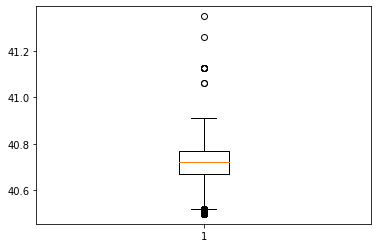

In [29]:
plt.boxplot(clean_traffic_df.latitude)

In [30]:
traffic_df.longitude.describe()

count    1.479119e+06
mean    -6.464138e+01
std      2.453079e+01
min     -2.013600e+02
25%     -7.397122e+01
50%     -7.391586e+01
75%     -7.382619e+01
max      0.000000e+00
Name: longitude, dtype: float64

In [31]:
clean_traffic_df = traffic_df[traffic_df.longitude > -74.4]
clean_traffic_df = clean_traffic_df[clean_traffic_df.longitude < -60]

In [32]:
#Save df to csv 
clean_traffic_df.to_csv(path_or_buf='accident_df.csv')

In [33]:
#2019-09-03 12.30AM
clean_traffic_df.groupby(clean_traffic_df.index.month)['number_of_persons_injured'].sum()

datetime
1     25433.0
2     22229.0
3     25911.0
4     23702.0
5     27479.0
6     28039.0
7     31398.0
8     31379.0
9     31327.0
10    31328.0
11    28835.0
12    29231.0
Name: number_of_persons_injured, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x1a2dca05f8>,
 'caps': [<matplotlib.lines.Line2D at 0x1a2dca0cc0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a2dca0208>],
 'medians': [<matplotlib.lines.Line2D at 0x1a2dcb4390>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a2dcb46d8>],
 'means': []}

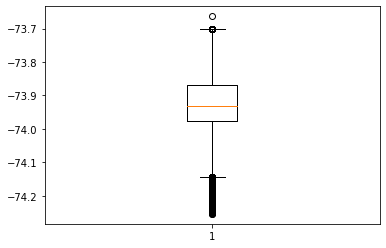

In [34]:
plt.boxplot(clean_traffic_df.longitude)

In [35]:
clean_traffic_df.latitude.shape

(1293105,)

Got rid of plain incorrect vvalues. look at a map of NY City limits and define max and min lat and long values

Lat     MAX   40.738912
        MIN   40.496052
Long    MAX  -73.910391
        MIN  -74.255730

In [36]:
len(traffic_df)

1479119

In [37]:
traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1479119 entries, 2019-04-16 00:00:00 to 2012-07-01 09:59:00
Data columns (total 30 columns):
date                             1479119 non-null datetime64[ns]
time                             1479119 non-null object
borough                          1036690 non-null object
zip_code                         1036515 non-null object
latitude                         1293243 non-null float64
longitude                        1479119 non-null float64
location                         1293243 non-null object
on_street_name                   1195440 non-null object
cross_street_name                1006555 non-null object
off_street_name                  191528 non-null object
number_of_persons_injured        1479102 non-null float64
number_of_persons_killed         1479088 non-null float64
number_of_pedestrians_injured    1479119 non-null int64
number_of_pedestrians_killed     1479119 non-null int64
number_of_cyclist_injured        1479119 non-nu

[Back to Contents](#Contents)

## Conversion of Lat and Long to mercator <a id='mercator'></a>

In [38]:
#prepare a new dataframe that will hold the date, long, lat and x and y coordinates
coordinate_df = clean_traffic_df[['date', 'time', 'longitude', 'latitude']].copy()
#when looking at .head() of df, do not see time values. Try filtering based on time to see if it works:
#coordiante_df[coordiante_df['datetime'] >= '2019-04-16 12:00'].head()

In [39]:
len(coordinate_df)

1293105

Convert latitude and longitude to WGS with pyproj

In [40]:
# Useful method found here: http://all-geo.org/volcan01010/2012/11/change-coordinates-with-pyproj/
#First, define the projection we want using the correct EPSG # found at www.spatialreference.org
epsg_32618 = Proj("+proj=utm +zone=18T +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
wgs84 = Proj("+init=EPSG:4326") # LatLon with WGS84 datum used by GPS units and Google Earth
#Now should be able to pass longitude and latitude (note, in that order) to get coordinates
#espg_32118(-73.98091, 40.737885)
list_of_coords = [epsg_32618(y, x) for y, x in zip(clean_traffic_df.longitude, clean_traffic_df.latitude)]


In [41]:
#coordiante_df[['y'], ['x']] = pd.DataFrame(list_of_coords.values.tolist(), index = coordiante_df.index)
#Converting list of coordinates into dataframe. Need datetime index to be able to merge below
coord_df =  pd.DataFrame(list_of_coords, columns = ['y', 'x'], index = clean_traffic_df.index)
coord_df.head()

,y,x
datetime,,
2019-04-16,586046.344512,4.510160e+06
2019-04-16,599375.548769,4.513088e+06
2019-04-16,599407.480337,4.509385e+06
2019-04-16,605341.759287,4.502370e+06
2019-04-16,588461.524222,4.518214e+06


In [42]:
len(coord_df), len(coordinate_df)

(1293105, 1293105)

In [43]:
#combine dataframe with latitude and longitude with x and y coordinate. In case need both...
coordinate_df[['y', 'x']] = coord_df[['y', 'x']]
all_coords_df = coordinate_df.copy()
#all_coords_df = pd.merge(coordiante_df, coord_df, left_index=True, right_index=True)

In [44]:
coordinate_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1293105 entries, 2019-04-16 00:00:00 to 2012-07-01 09:59:00
Data columns (total 6 columns):
date         1293105 non-null datetime64[ns]
time         1293105 non-null object
longitude    1293105 non-null float64
latitude     1293105 non-null float64
y            1293105 non-null float64
x            1293105 non-null float64
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 69.1+ MB


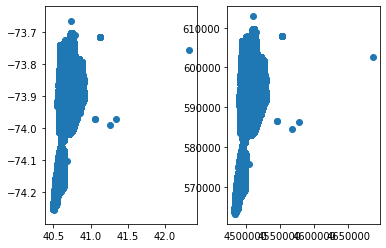

In [45]:
plt.subplot(1,2,1)
plt.scatter(x=all_coords_df['latitude'], y=all_coords_df['longitude'])
plt.subplot(1,2,2)
plt.scatter(x=all_coords_df['x'], y=all_coords_df['y'])


In [46]:
#lets remove more of the outlying points, based on the visualization above
all_coords_df = all_coords_df[all_coords_df.latitude < 41]
all_coords_df = all_coords_df[all_coords_df.longitude < 73.7]

In [47]:
len(all_coords_df)

1293094

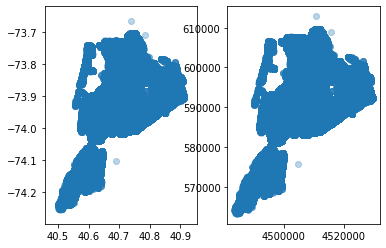

In [48]:
plt.subplot(1,2,1)
plt.scatter(x=all_coords_df['latitude'], y=all_coords_df['longitude'], alpha=0.3)
plt.subplot(1,2,2)
plt.scatter(x=all_coords_df['x'], y=all_coords_df['y'], alpha=0.3)

In [49]:
all_coords_df = all_coords_df[all_coords_df.x < 4535000]

In [50]:
all_coords_df.head(5)
all_coords_df.to_pickle('all_coords_df.pkl')

In [2]:
load_coords = True
if load_coords:
    all_coords_df = pd.read_pickle('all_coords_df.pkl')

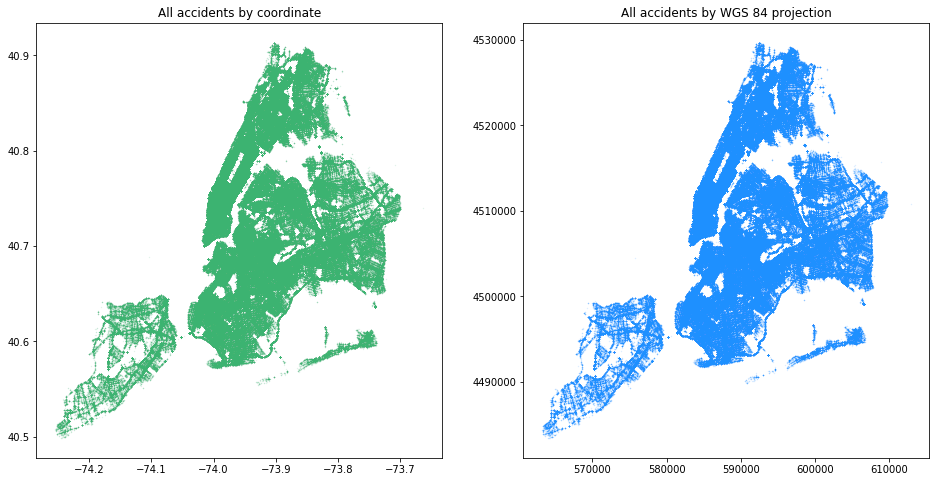

In [38]:
#plot using coodinates. reverse X-axis with plt.gca.invert_xaxis
fig = plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
_ = plt.scatter(x=all_coords_df['longitude'], y=all_coords_df['latitude'], \
                alpha=0.2, s=0.1, color='mediumseagreen')
_ = plt.title('All accidents by coordinate')

plt.subplot(1,2,2)

#plot now using coodinates. reverse X-axis with plt.gca.invert_xaxis
_ = plt.scatter(x=all_coords_df['y'], y=all_coords_df['x'], \
                alpha=0.2, s=0.1, color='dodgerblue')
_ = plt.title('All accidents by WGS 84 projection')
plt.savefig('accident_map.png', transparent=True)

In [ ]:
#now plot using coodinates. reverse X-axis with plt.gca.invert_xaxis
fig = plt.figure(figsize=(8,8))
_ = plt.scatter(x=all_coords_df['latitude'], y=all_coords_df['longitude'], \
                alpha=0.2, s=0.1, color='mediumseagreen')
_ = plt.gca().invert_xaxis()
plt.savefig('accident_map_coord.png')

In [5]:
all_coords_df.head()

,date,time,longitude,latitude,y,x
datetime,,,,,,
2019-04-16,2019-04-16,0:00,-73.98091,40.737885,586046.344512,4.510160e+06
2019-04-16,2019-04-16,0:00,-73.82261,40.762756,599375.548769,4.513088e+06
2019-04-16,2019-04-16,0:00,-73.82282,40.729404,599407.480337,4.509385e+06
2019-04-16,2019-04-16,0:00,-73.75374,40.665485,605341.759287,4.502370e+06
2019-04-16,2019-04-16,0:00,-73.95117,40.810173,588461.524222,4.518214e+06


End of notebook